## Project Objective

The goal of this project was to forecast weekly sales across multiple Walmart stores using historical and external factors such as holidays, temperature, fuel prices, CPI, and unemployment rates.
Accurate forecasting enables better inventory management, staff allocation, and strategic decision-making across the company’s retail network.

### Models to be used:
1. LSTM is a type of Recurrent Neural Network (RNN) specifically designed to capture temporal dependencies and long-term patterns in sequential data.It effectively handles non-linear relationships, seasonality, and holiday effects that are often present in retail sales data. 
Why LSTM : 
- Learns from past sequences (ex. previous 12 weeks) to predict the next week’s sales.

- Handles complex interactions between time series and exogenous features (like CPI, unemployment, temperature).

- Robust to noise and outliers when combined with Box–Cox transformation and feature scaling.
<br>
2. XGBoost is a tree-based ensemble learning method known for its speed, accuracy, and robustness in structured tabular data. It serves as a strong baseline model to benchmark against deep learning methods.
Why XGBoost:
- Works well with engineered features such as lagged sales, moving averages, and exogenous factors.
- Provides feature importance insights, helping interpret what drives sales variation.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
df = pd.read_csv('cleaned_data.csv')
df = df.drop(columns=['Unnamed: 0'])

## LSTM

In [ ]:
df.sort_values(['Store', 'Date'], inplace=True)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Week,Month,Year,Rolling_Mean,Rolling_Std,Weekly_Sales_Scaled
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,5,2,2010,"Axes(0.125,0.11;0.775x0.77)","Axes(0.125,0.11;0.775x0.77)",175.399049
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,6,2,2010,"Axes(0.125,0.11;0.775x0.77)","Axes(0.125,0.11;0.775x0.77)",175.347784
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,7,2,2010,"Axes(0.125,0.11;0.775x0.77)","Axes(0.125,0.11;0.775x0.77)",174.454576
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,8,2,2010,"Axes(0.125,0.11;0.775x0.77)","Axes(0.125,0.11;0.775x0.77)",168.091198
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,9,3,2010,"Axes(0.125,0.11;0.775x0.77)","Axes(0.125,0.11;0.775x0.77)",172.717963


### Scaling the features

In [3]:
from sklearn.preprocessing import MinMaxScaler
features = ['Weekly_Sales_Scaled', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [4]:
def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window, 0])  # first column = Weekly_Sales_Scaled
    return np.array(X), np.array(y)

all_X, all_y = [], []

for store_id, store_df in df.groupby('Store'):
    arr = store_df[features].values
    X, y = create_sequences(arr, window=12)
    all_X.append(X)
    all_y.append(y)

X = np.vstack(all_X)
y = np.hstack(all_y)

print(X.shape, y.shape)

(5895, 12, 6) (5895,)


### Train/Test Split
80/20 ratio split

In [5]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

### Training the model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


Epoch 1/50


c:\Users\ADMIN\train\walmart_sales_forcast\env\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0152 - val_loss: 0.0013
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 8/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 9/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 11/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 12/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

### Metrics and performance
Using mean square error & mean absolute error.

In [ ]:
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE: 0.0334, MAE: 0.0224


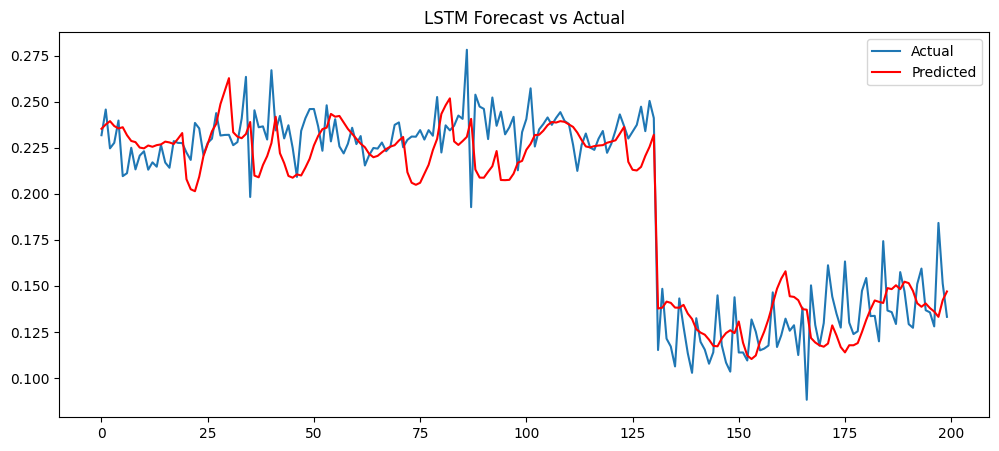

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test[:200], label='Actual')
plt.plot(preds[:200], label='Predicted', color='red')
plt.legend()
plt.title('LSTM Forecast vs Actual')
plt.show()

## XGBoost

In [4]:
df = pd.read_csv('cleaned_data.csv')
df= df.drop(columns=['Unnamed: 0'])
df['Date'] = pd.to_datetime(df['Date'])

### Create lag features

In [5]:
lags = [1, 2, 3, 4, 8, 12]
for lag in lags:
    df[f'lag_{lag}'] = df.groupby('Store')['Weekly_Sales_Scaled'].shift(lag)
df = df.dropna()

features = [f'lag_{l}' for l in lags] + ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
target = 'Weekly_Sales_Scaled'

### Train/Test Split

In [6]:
split_date = df['Date'].quantile(0.8)
train = df[df['Date'] <= split_date]
test  = df[df['Date'] >  split_date]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

### Fitting the Model

In [7]:
from xgboost import XGBRegressor
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Metrics

In [11]:
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)

print(f"XGBoost RMSE: {rmse:.4f}, MAE: {mae:.4f}")

XGBoost RMSE: 2.3643, MAE: 1.7861


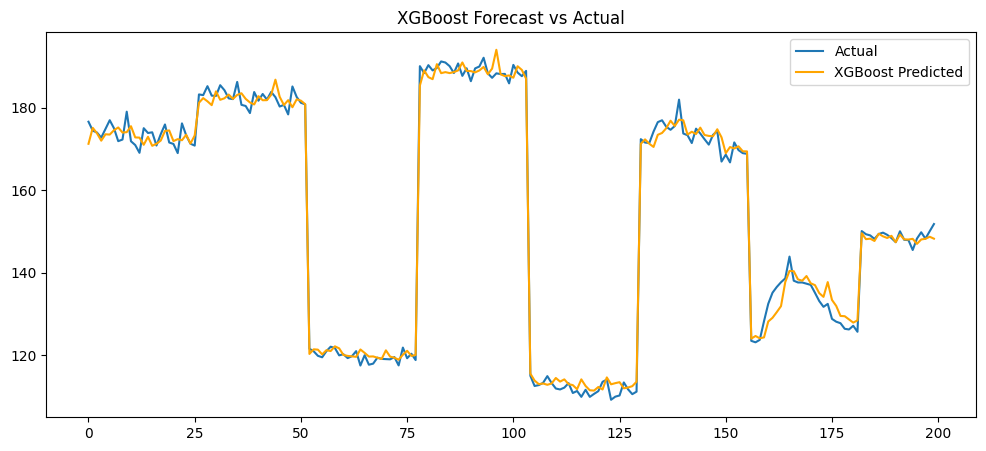

In [12]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label='Actual')
plt.plot(preds[:200], label='XGBoost Predicted', color='orange')
plt.legend()
plt.title('XGBoost Forecast vs Actual')
plt.show()

## Inference
- LSTM -
RMSE : 0.0334,
MSE : 0.0224
<br>
LSTM is able to captures long-term time dependencies and seasonality.

- XGBoost - RMSE :2.3643
, MSE : 1.7861<br>
XGBoost performed significantly worse in this time series context due to limited sequential awareness and inability to capture temporal dependencies beyond the engineered lags<br>
### Conclusion :
The LSTM model significantly outperformed XGBoost, demonstrating its superior ability to capture weekly trends, holiday effects, and seasonal fluctuations in sales data.